In [1]:
#!/usr/bin/env python
# coding: utf-8

import functools
import nest_asyncio
import os
import traceback
import pandas as pd
import telebot
from icecream import ic
from IPython import get_ipython
from IPython.utils.capture import capture_output
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from typing import TypedDict, Annotated, Sequence
import operator
from langchain import hub
from gsheet_handler import GSheetHandler
import importlib

nest_asyncio.apply()
module = importlib.import_module('gsheet_handler')
importlib.reload(module)
ggl = module.GSheetHandler('google_sheet_key.json')

# main.py
import json
import os
import telebot

# Загрузка конфигурации из JSON-файла
with open('config.json') as config_file:
    config = json.load(config_file)

# Установка переменных окружения
os.environ["LANGCHAIN_API_KEY"] = config["LANGCHAIN_API_KEY"]
os.environ["OPENAI_API_KEY"] = config["OPENAI_API_KEY"]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"]="nlmk_bot"
TELEGRAMM_API_KEY = config["TELEGRAM_BOT_TOKEN"]

no docx
no docx


In [2]:
# Extract data from Google Sheets
example_dialog = ggl.extract_data_from_google_sheet('https://docs.google.com/spreadsheets/d/1sBAFF62fAjSdPrGYTWgpjmBjLRiFCb8DNAX8ZypI-_U/edit?gid=0#gid=0', 0)
example_dialog.to_csv('example_dialog.csv', index=False)

support = ggl.extract_data_from_google_sheet('https://docs.google.com/spreadsheets/d/1C3m50L3iUWhkkrp5CWEmksVRAkA8y4hX6m2tYgS8-4I/edit?gid=1891107571#gid=1891107571', 0)
support.to_csv('support.csv', index=False)

# New Google Sheets link for "помещения и сооружения"
facilities = ggl.extract_data_from_google_sheet('https://docs.google.com/spreadsheets/d/19oNWcJstB1fJRqJAbi1YKygUlMqs91fF8-Jw-OTvPXo/edit?gid=362855495#gid=362855495', 0)
facilities.to_csv('facilities.csv', index=False)

# New Google Sheets link for "особые экономические зоны и технопарки"
special_economic_zones = ggl.extract_data_from_google_sheet('https://docs.google.com/spreadsheets/d/1p24i_RrKPCScLhfMNcw5C61t4iWeOpIziG45rukY9TY/edit?usp=sharing', 0)
special_economic_zones.to_csv('special_economic_zones.csv', index=False)


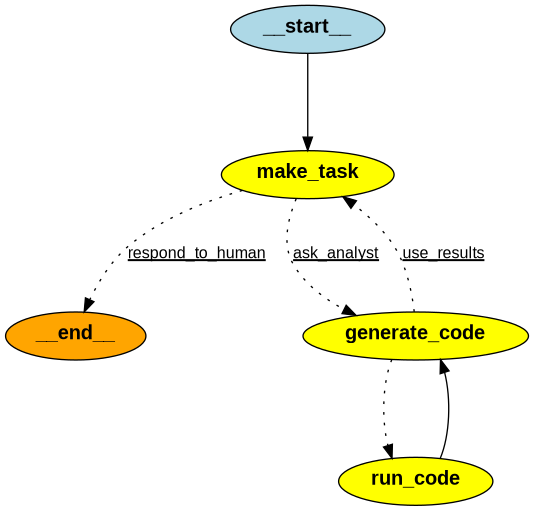

In [3]:
ic.disable()

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next_node: str
    python_code: str
    ask_analyst: str
    respond_to_human: str
    spreadsheets_link: str
    values: dict
    variables: dict

def trace(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        print(f"Вызов функции: {func.__name__}")
        return func(*args, **kwargs)
    return wrapper

def capture_output_and_errors(code, variables=None):
    if variables is None:
        variables = {}
    ipython = get_ipython()
    captured_output = ""
    captured_error = ""
    exec_globals = {}
    exec_globals.update(variables)
    exec_locals = {}
    with capture_output() as captured:
        try:
            code_lines = code.strip().split('\n')
            if not code_lines:
                return ""
            last_expr = code_lines[-1]
            code_body = '\n'.join(code_lines)
            if code_body:
                exec(code_body, exec_globals, exec_locals)
            if last_expr:
                try:
                    result = eval(last_expr, exec_globals, exec_locals)
                    if result is not None:
                        print(result)
                except Exception as eval_exception:
                    captured_error = f"Error in expression: {last_expr}\n{traceback.format_exc()}"
        except Exception as exec_exception:
            captured_error = f"Error in code body:\n{traceback.format_exc()}"
    exec_globals.update(exec_locals)
    captured_output = captured.stdout.strip()
    if captured_error:
        captured_output += f'\n{captured_error}'
    return captured_output, exec_globals

llm = ChatOpenAI(temperature=0, model="gpt-4o")

def make_task(state):
    messages = state['messages']
    prompt = hub.pull("mlenparrot/invest_mos_bot_task")
    ic(messages[-1])
    chain = prompt | llm
    result = chain.invoke({'chat_history': messages})
    ic(result)
    next_node = result.get('next_step', 'respond_to_human')
    respond_to_human = result.get('respond_to_human', '')
    ask_analyst = result.get('ask_analyst', '')
    return {"messages": [AIMessage(content=str(result))], 'next_node': next_node, 'respond_to_human': respond_to_human, 'ask_analyst': ask_analyst}

def load_data(state):
    messages = state['messages']
    prompt = hub.pull("mlenparrot/exec_loader")
    chain = prompt | llm
    result = chain.invoke({'chat_history': messages})
    ic(messages[-1])
    next_node = result.get('next_step', 'pass')
    spreadsheets_link = result.get('spreadsheets_link', '')
    respond_to_human = result.get('respond_to_human', '')
    if next_node == 'pass' and respond_to_human != '':
        return {'next_node': next_node, "messages": [AIMessage(content=str('ПОЛЬЗОВАТЕЛЬ НЕ ПРЕДОСТАВИЛ ДАННЫЕ!'))], 'values': {'no_data': 'ПОЛЬЗОВАТЕЛЬ НЕ ПРЕДОСТАВИЛ ДАННЫЕ!'}}
    return {'next_node': next_node, 'spreadsheets_link': spreadsheets_link}

def load_table(state):
    spreadsheets_link = state.get('spreadsheets_link', '')
    stat_raw = pd.DataFrame()
    try:
        stat_raw = ggl.extract_data_from_google_sheet(spreadsheets_link, 0)
        result = f'ТАБЛИЦА {spreadsheets_link}  УЖЕ УСПЕШНО ЗАГРУЖЕНА В ПЕРЕМЕННУЮ stat_raw. ИСПОЛЬЗУЙ ПЕРЕМЕННУЮ stat_raw ДЛЯ РАБОТЫ С ЭТОЙ ТАБЛИЦЕЙ!'
    except Exception as e:
        ic(f"Error: {e}")
        result = 'Ссылка не рабочая! ПОЛЬЗОВАТЕЛЬ НЕ ПРЕДОСТАВИЛ ДАННЫЕ!'
    return {"values": {'stat_raw': stat_raw}, "messages": [AIMessage(content=str(result))]}

def generate_code(state):
    messages = state['messages']
    ask_analyst = state['ask_analyst']
    next_node = state['next_node']
    prompt = hub.pull("mlenparrot/invest_mos_bot_exec")
    values = state.get('values', {'no_data': 'ПОЛЬЗОВАТЕЛЬ НЕ ПРЕДОСТАВИЛ ДАННЫЕ!'})
    chain = prompt | llm
    result = chain.invoke({'question': ask_analyst, 'values': str(values), 'chat_history': messages})
    next_node = result.get('next_step', 'use_results')
    ic(result)
    return {'python_code': result.get('python_code', ''), 'next_node': next_node}

def run_code(state):
    python_code = state['python_code']
    ic(python_code)
    variables = state.get('variables', {}) or {}
    values = state.get('values', {}) or {}
    code_result = capture_output_and_errors(python_code, {**values, **variables})
    ic(values, variables)
    ic(code_result)
    result = f'''
    КОД НАПИСАН
    ====== python_code ======
    {python_code}
    ====== python_code ======
    КОД ВЫПОЛНЕН
    ====== результат run_code ======
    {code_result[0]}
    ====== результат run_code ======
    ВЫБЕРИ СЛЕДУЮЩИЙ ШАГ
    '''
    ic(result)
    return {"messages": [AIMessage(content=result)], 'variables': code_result[1]}

def get_state(state):
    return state.get('next_node', 'respond_to_human')

research_graph = StateGraph(State)
#research_graph.add_node("load_data", load_data)
research_graph.add_node("make_task", make_task)
research_graph.set_entry_point("make_task")
research_graph.add_node("generate_code", generate_code)
research_graph.add_node("run_code", run_code)
#research_graph.add_node("load_table", load_table)

research_graph.add_edge("run_code", "generate_code")
#research_graph.add_edge("load_table", "make_task")

#research_graph.add_conditional_edges("load_data", get_state, {'load_table': 'load_table', "pass": "make_task"})
research_graph.add_conditional_edges("make_task", get_state, {"ask_analyst": "generate_code", "respond_to_human": END})
research_graph.add_conditional_edges("generate_code", get_state, {"run_code": "run_code", "use_results": "make_task"})

graph = research_graph.compile()

from IPython.display import Image
Image(graph.get_graph().draw_png())



In [4]:
#1/0

In [ ]:
def gpt_answer(question, recursion_limit=100):
    inputs = {"messages": [HumanMessage(content=question)]}
    config = {"recursion_limit": recursion_limit}
    try:
        for output in graph.stream(inputs, config=config):
            for key, value in output.items():
                ic(key, value)
        return value['messages'][-1].content
    except Exception as e:
        print(f"Error: {e}")
        return "{'respond_to_human': 'Я не справился, спросите как-то попроще.'}"

bot = telebot.TeleBot(TELEGRAMM_API_KEY)

@bot.message_handler(content_types=['text'])
def handle_message(message):
    if 'консультант' in message.text:
        question = message.text.replace('консультант', '').strip()
        bot.send_message(message.chat.id, 'Надо подумать... Думать я могу долго, иногда пару минут')
        answer = gpt_answer(question)
        bot.send_message(message.chat.id, eval(answer).get('respond_to_human', 'не могу ответить, спросите что-нибудь попроще'))

while True:
    try:
        bot.polling(none_stop=True)
    except:
        print('Error occurred, retrying...')
        time.sleep(60)

In [ ]:
sudo apt update
sudo apt install certbot
